<a href="https://colab.research.google.com/github/HWNAOY/human-unet/blob/main/Human_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [33]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-l77__r01
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-l77__r01
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
!git clone https://github.com/HWNAOY/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


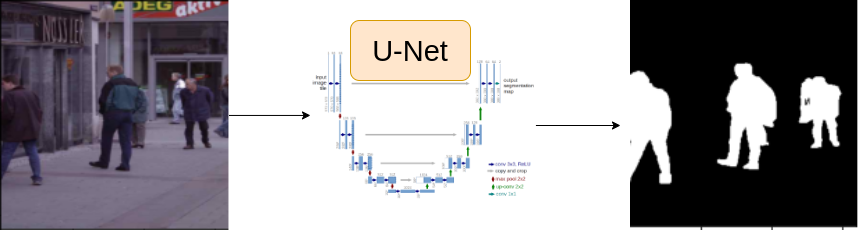

In [35]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [36]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

#Setup 

In [37]:
CV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = 'content/'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16
DEVICE = 'cuda'
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [38]:
df = pd.read_csv(CV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [39]:
row = df.iloc[4]

image = row.images
mask = row.masks

image = cv2.imread(image)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask,cv2.IMREAD_GRAYSCALE)/255.0
mask = np.expand_dims(mask,axis=-1)
print("image shape",image.shape)
print("mask shape",mask.shape)

image shape (408, 612, 3)
mask shape (408, 612, 1)


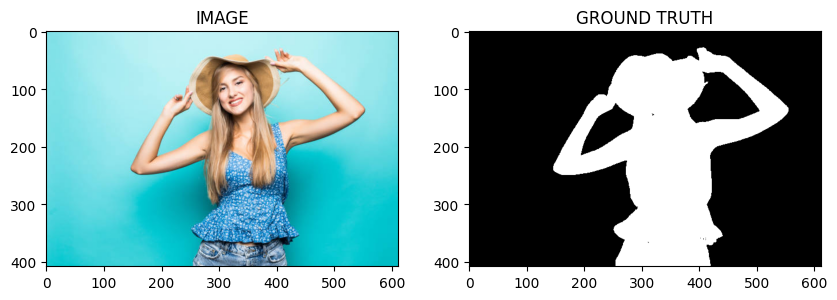

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [41]:
train_df,valid_df = train_test_split(df,test_size=0.2,random_state=42)

# Customizing Dataset 

In [42]:
# Augmentation Functions

# For classification augmentation are just applied on training data
# and not on label. In segmentation we need to apply on mask as well.
import albumentations as A

In [43]:
def get_train_augs():
  return A.Compose([A.Resize(IMAGE_SIZE,IMAGE_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)],
                    is_check_shapes=False)
def get_valid_augs():
  return A.Compose([A.Resize(IMAGE_SIZE,IMAGE_SIZE)],
                    is_check_shapes=False)

In [44]:
from torch.utils.data import Dataset

In [45]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations
  def __len__(self):

    return len(self.df)
  def __getitem__(self,idx):

    row = self.df.iloc[idx]
    image = row.images
    mask = row.masks
    image = cv2.imread(image)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask,cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask,axis=-1)
    
    if self.augmentations:
      data = self.augmentations(image=image,mask=mask)
      image = data['image']
      mask = data['mask']
    
    #Convert (c,h,w) to (h,w,c)
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)
    
    image = torch.tensor(image)/255.0
    mask = torch.round(torch.tensor(mask)/255.0)
    return image,mask

In [46]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_valid_augs())

In [47]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


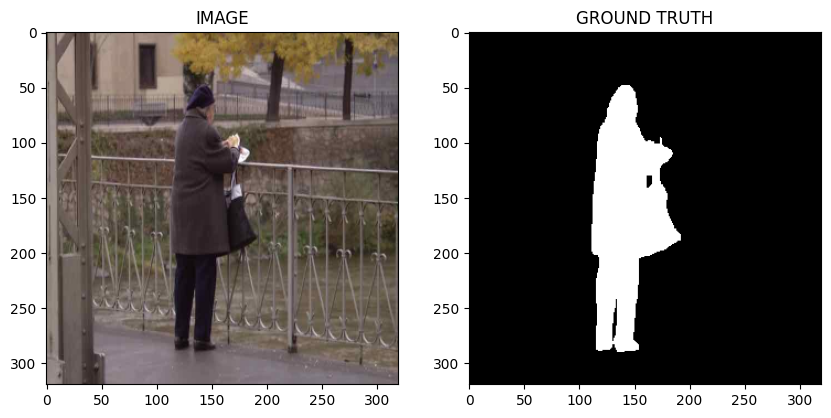

In [48]:
idx = 4
image,mask = trainset[idx]
helper.show_image(image,mask)

In [49]:
# Loading in batches
from torch.utils.data import DataLoader

In [50]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [51]:
print(f"Total number of batches in train : {len(trainloader)}")
print(f"Total number of batches in valid : {len(validloader)}")

Total number of batches in train : 15
Total number of batches in valid : 4


In [52]:
for image,mask in trainloader:
  break
print(f"One batch of image shape:{image.shape}")
print(f"One batch of mask shape:{mask.shape}")

One batch of image shape:torch.Size([16, 3, 320, 320])
One batch of mask shape:torch.Size([16, 1, 320, 320])


# Segmentation Model

In [53]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [54]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
  
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None 
    )

  def forward(self,images,mask=None):
    logits = self.arc(images)

    if mask!=None:
      loss1 = DiceLoss(mode='binary')(logits,mask)
      loss2 = nn.BCEWithLogitsLoss()(logits,mask)
      return logits,loss1+loss2
    return logits

In [55]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Train Model

In [56]:
def train_fn(data_loader,model,optimizer):

  model.train()
  total_loss = 0.0
  for image,mask in tqdm(data_loader):
    image = image.to(DEVICE)
    mask = mask.to(DEVICE)
    optimizer.zero_grad()
    
    logits,loss = model(image,mask)
    loss.backward()
    total_loss+=loss.item()
    optimizer.step()
  return total_loss/len(data_loader)



In [60]:
# Does not have optimizer
def valid_fn(data_loader,model):

  model.eval()
  total_loss = 0.0

  # No gradient computation it to be done
  with torch.no_grad():
    for image,mask in tqdm(data_loader):
      image = image.to(DEVICE)
      mask = mask.to(DEVICE)
      logits,loss = model(image,mask)
      #loss.backward()
      total_loss+=loss.item()
  return total_loss/len(data_loader)

In [61]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [62]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader,model,optimizer)
  valid_loss = valid_fn(validloader,model)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_model_pt')
    print('Saved Model')
    best_valid_loss = valid_loss
  
  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Saved Model
Epoch : 1 Train Loss : 0.4225946843624115 Valid Loss : 0.42876021564006805


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Saved Model
Epoch : 2 Train Loss : 0.3367325613896052 Valid Loss : 0.3950018435716629


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Saved Model
Epoch : 3 Train Loss : 0.2907165169715881 Valid Loss : 0.35398323833942413


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Saved Model
Epoch : 4 Train Loss : 0.28772239089012147 Valid Loss : 0.2530633211135864


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


Saved Model
Epoch : 5 Train Loss : 0.225038214524587 Valid Loss : 0.2455008700489998


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Saved Model
Epoch : 6 Train Loss : 0.2447864313920339 Valid Loss : 0.20621053874492645


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Saved Model
Epoch : 7 Train Loss : 0.19763514399528503 Valid Loss : 0.19864298775792122


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


Epoch : 8 Train Loss : 0.18724433581034342 Valid Loss : 0.208485446870327


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch : 9 Train Loss : 0.16581324289242427 Valid Loss : 0.22772972658276558


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch : 10 Train Loss : 0.15984310160080592 Valid Loss : 0.2505169454962015


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epoch : 11 Train Loss : 0.156402022143205 Valid Loss : 0.20273754745721817


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Saved Model
Epoch : 12 Train Loss : 0.13981322447458902 Valid Loss : 0.18972432240843773


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Saved Model
Epoch : 13 Train Loss : 0.1273383691906929 Valid Loss : 0.15506824105978012


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch : 14 Train Loss : 0.14737546940644583 Valid Loss : 0.17125135846436024


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch : 15 Train Loss : 0.1098870282371839 Valid Loss : 0.19605371728539467


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch : 16 Train Loss : 0.10956566284100215 Valid Loss : 0.187082901597023


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch : 17 Train Loss : 0.12059322446584701 Valid Loss : 0.16468624770641327


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch : 18 Train Loss : 0.1170922632018725 Valid Loss : 0.2384098321199417


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


Epoch : 19 Train Loss : 0.11399260212977727 Valid Loss : 0.2063125167042017


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch : 20 Train Loss : 0.14349597295125324 Valid Loss : 0.42149780690670013


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch : 21 Train Loss : 0.22080070277055105 Valid Loss : 0.23806660249829292


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


Epoch : 22 Train Loss : 0.15505421857039134 Valid Loss : 0.21862401068210602


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epoch : 23 Train Loss : 0.12778750558694205 Valid Loss : 0.22079146280884743


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch : 24 Train Loss : 0.15065560936927797 Valid Loss : 0.24612247571349144


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

Epoch : 25 Train Loss : 0.11455343465010324 Valid Loss : 0.2773619443178177


# Results

In [67]:
idx = 4
model.load_state_dict(torch.load('/content/best_model_pt'))
image,mask = validset[idx]

# Unsqueeze is done to add one dimention for batches (C,H,W) to(1,C,H,W)
logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1

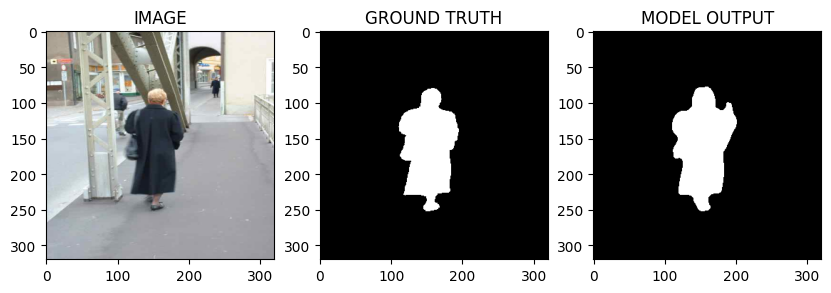

In [68]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

albumentation documentation : https://albumentations.ai/docs/